In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl, matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn import preprocessing

In [2]:
tvdb_series_df = pd.read_csv("data/output/tvdb_series.csv", index_col="imdb_id")
my_ratings_df = pd.read_csv("data/input/my_ratings.csv", index_col="imdb_id")
imdb_series_df = pd.read_csv("data/output/imdb_series.csv", index_col="id")

In [3]:
cols_to_use = tvdb_series_df.columns.difference(imdb_series_df.columns)
df1 = pd.merge(imdb_series_df, tvdb_series_df[cols_to_use], how="outer", left_index=True, right_index=True)

cols_to_use = my_ratings_df.columns.difference(df1.columns)
tv_df = pd.merge(df1, my_ratings_df[cols_to_use], how="outer", left_index=True, right_index=True)
tv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1937 entries, tt0092337 to tt9879074
Data columns (total 86 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               1936 non-null   object 
 1   type               1936 non-null   object 
 2   start_year         1936 non-null   float64
 3   end_year           1084 non-null   float64
 4   ep_length          1936 non-null   float64
 5   n_seasons          1936 non-null   object 
 6   n_episodes         1936 non-null   float64
 7   popularity_rank    1936 non-null   float64
 8   n_ratings          1936 non-null   float64
 9   rating_avg         1936 non-null   float64
 10  rating_top1000     1936 non-null   float64
 11  rating_us          1936 non-null   float64
 12  rating_row         1936 non-null   float64
 13  rating_M           1936 non-null   float64
 14  rating_F           1936 non-null   float64
 15  rating_0to18       1936 non-null   object 
 16  rating_M_0to18  

# Correlation

In [4]:
corr_matrix = tv_df.corr()

In [5]:
my_rating_corr = corr_matrix["my_rating"]
genres_mask = corr_matrix.filter(like="genre").columns
rating_mask = corr_matrix.filter(like="rating").columns.drop(["my_rating"])

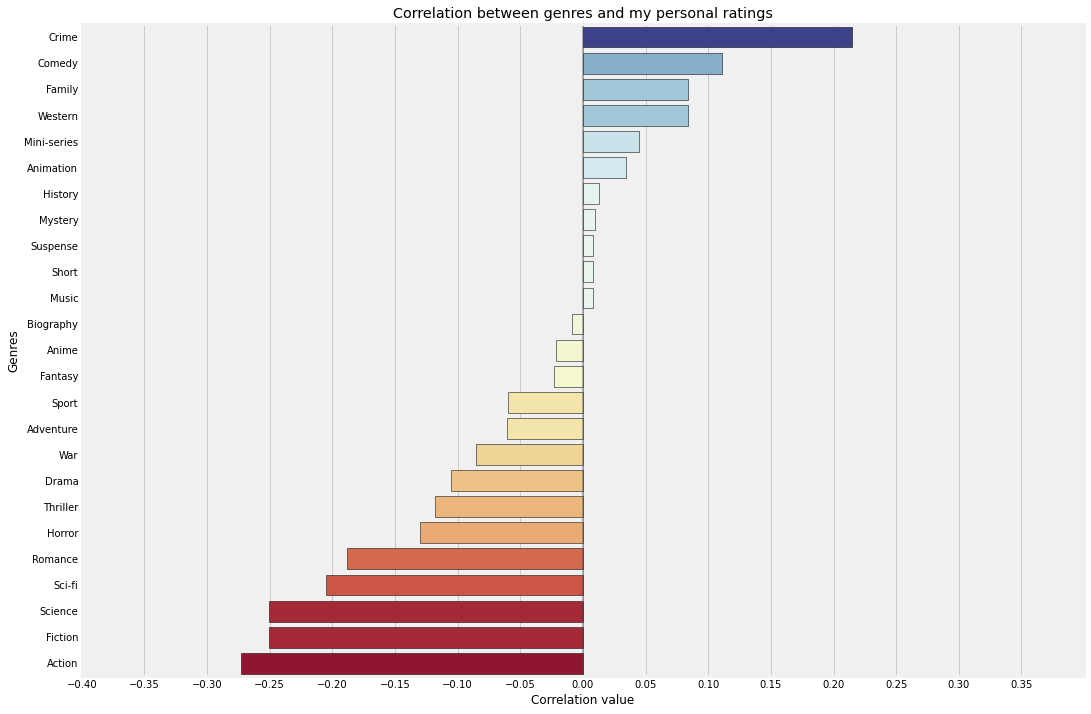

In [6]:
# Sort values.
sorted_corr_genres = my_rating_corr[genres_mask].sort_values(ascending=False)
# Remove nan values.
sorted_corr_genres = sorted_corr_genres[np.logical_not(np.isnan(sorted_corr_genres))]
# Normalize values to assign proper colors.
norm_sorted_corr_genres = preprocessing.MinMaxScaler().fit_transform(sorted_corr_genres.values.reshape(-1,1)).flatten()
# Prettify labels on y axis.
labels = [l.split("_")[1].capitalize() for l in sorted_corr_genres.index]

fig, ax = plt.subplots(figsize=(16,12))

sns.barplot(y=labels, x=sorted_corr_genres, ax=ax, palette=mpl.cm.RdYlBu(norm_sorted_corr_genres), edgecolor="black")
ax.axvline(color='#414141', linewidth=1.5, alpha=.5)

ax.set_title("Correlation between genres and my personal ratings")
ax.set_xlim(-0.4,0.4)
ax.xaxis.set_ticks(np.arange(-0.4, 0.4, 0.05))
ax.set_xlabel("Correlation value")
ax.set_ylabel("Genres")

plt.show()

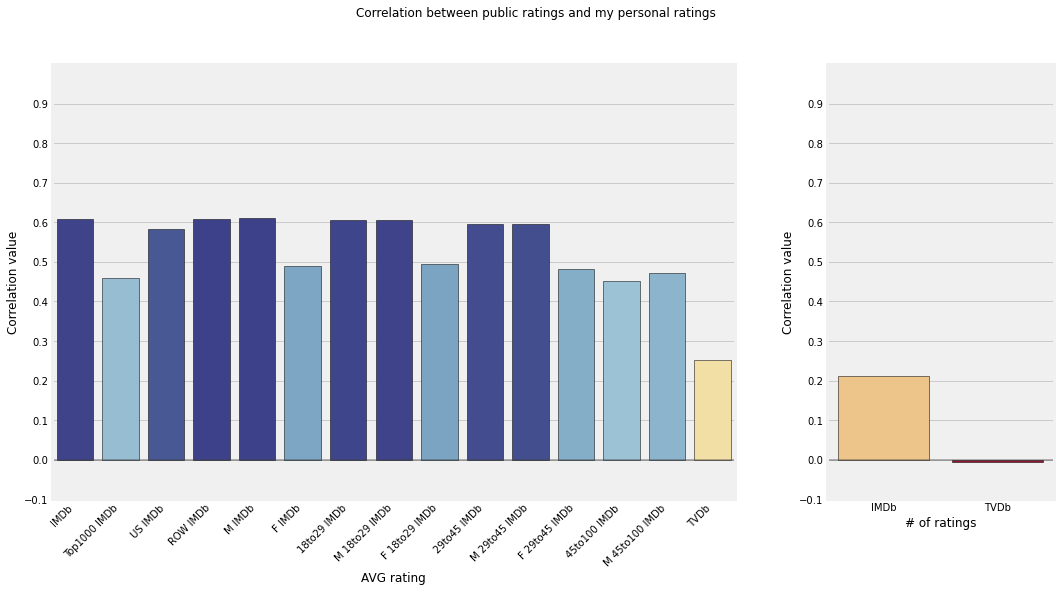

In [7]:
sorted_corr_rating = my_rating_corr[rating_mask]
norm_sorted_corr_rating = preprocessing.MinMaxScaler().fit_transform(sorted_corr_rating.values.reshape(-1,1)).flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), gridspec_kw={"width_ratios": [3, 1]})
plt.suptitle("Correlation between public ratings and my personal ratings")

# PLOT 1
y1 = sorted_corr_rating[1:-1]
x1 = ["IMDb", "Top1000 IMDb", "US IMDb", "ROW IMDb", "M IMDb", "F IMDb", "18to29 IMDb", "M 18to29 IMDb", "F 18to29 IMDb", 
      "29to45 IMDb", "M 29to45 IMDb", "F 29to45 IMDb", "45to100 IMDb", "M 45to100 IMDb", "TVDb"]
palette1 = mpl.cm.RdYlBu(norm_sorted_corr_rating[1:-1])

sns.barplot(y=y1, x=x1, ax=ax1, palette=palette1, edgecolor="black")
ax1.axhline(color='#414141', linewidth=1.5, alpha=.5)

ax1.set_xlabel("AVG rating")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim(-0.1,1.0)
ax1.yaxis.set_ticks(np.arange(-0.1, 1.0, 0.10))
ax1.set_ylabel("Correlation value")

# PLOT 2
x2 = ["IMDb", "TVDb"]
y2 = list((sorted_corr_rating[0], sorted_corr_rating[-1]))
palette2 = mpl.cm.RdYlBu(list((norm_sorted_corr_rating[0], norm_sorted_corr_rating[-1])))

sns.barplot(x=x2, y=y2, ax=ax2, palette=palette2, edgecolor="black")
ax2.axhline(color='#414141', linewidth=1.5, alpha=.5)

ax2.set_ylim(-0.1,1)
ax2.yaxis.set_ticks(np.arange(-0.1, 1, 0.10))
ax2.set_xlabel("# of ratings")
ax2.set_ylabel("Correlation value")


plt.show()

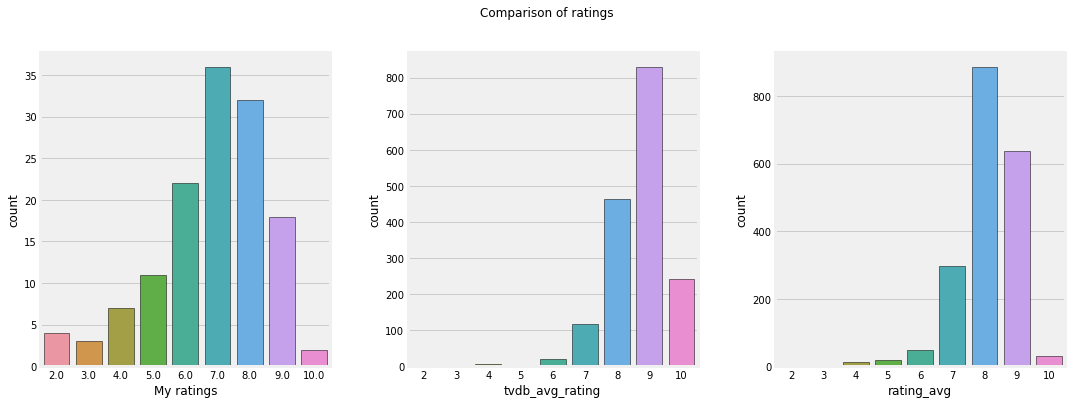

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 1, 1]})
fig.tight_layout(pad=5.0)
fig.suptitle("Comparison of ratings")

sns.countplot(tv_df["my_rating"], ax=ax1, edgecolor="#000000")
ax1.set_xlabel("My ratings")

# Discretizing and plotting TVDb ratings.
disc = pd.cut(tv_df["tvdb_avg_rating"], bins=range(1,11))
sns.countplot(disc.map(lambda x: x.right), ax=ax2, edgecolor="#000000")

# Discretizing and plotting IMDb ratings.
disc = pd.cut(tv_df["rating_avg"], bins=range(1,11))
sns.countplot(disc.map(lambda x: x.right), ax=ax3, edgecolor="#000000")

plt.show()

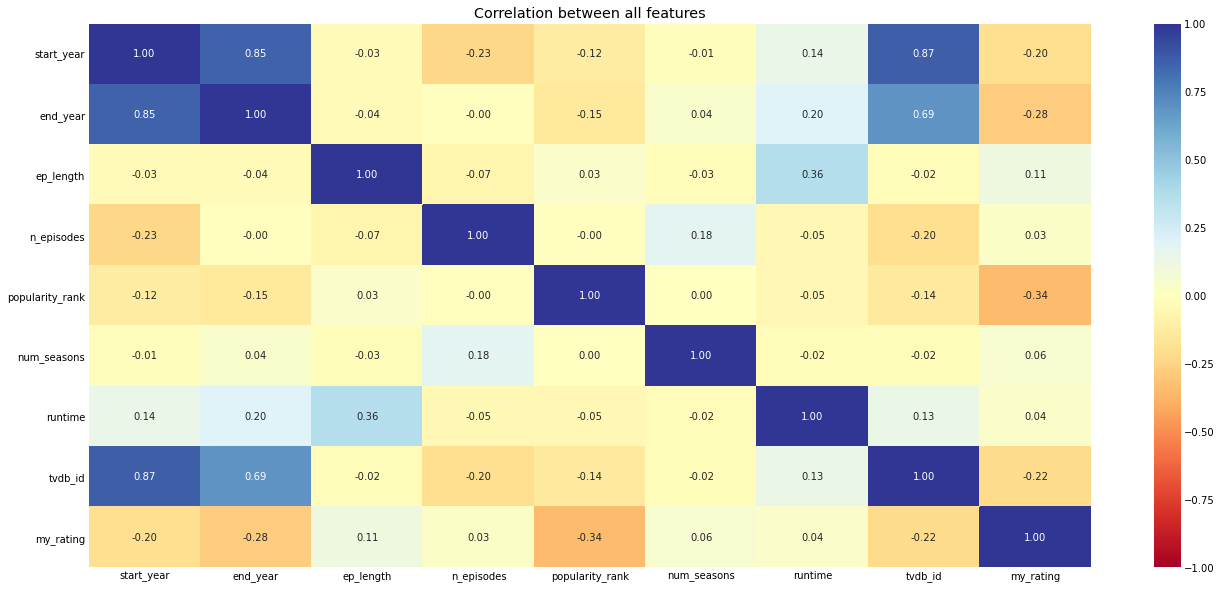

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
mask = rating_mask.append(genres_mask)
ax = sns.heatmap(tv_df.drop(mask, axis=1).corr(), annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="RdYlBu")
ax.set_title("Correlation between all features");